In [152]:
%load_ext autoreload
%autoreload 2

import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
import pickle
import copy as cp
import scipy.optimize
import casadi as cas


PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)

import src.vehicle as veh
import src.traffic_world as tw
# import src.IterativeBestResponseMPCMultiple as mibr
import src.car_plotting_multiple as cmplot
import src.multiagent_mpc as mpc
import src.solver_helper as helper
np.set_printoptions(precision=7)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
ego_veh = veh.Vehicle(.1)
ado_veh = veh.Vehicle(.1)
world = tw.TrafficWorld(2,0)
mpc_example = mpc.MultiMPC(ego_veh, None, [ado_veh], world)

In [155]:
params = {
    "N": 25,
    "dt": 0.2,
    "T": 5.0, 
    "svo_theta": np.pi/4.0,
}
position_list= [(1, 0)]
list_of_svo = [np.pi/4.0]
params["N"] = 1
params["T"] = params["dt"] * params["N"]

In [156]:
amb_MPC, amb_x0, all_other_MPC, all_other_x0 = helper.initialize_cars_from_positions(params["N"], params["dt"], world, params["svo_theta"], 
                                                                True, 
                                                                position_list, list_of_svo)    

In [157]:
# Plot initial conditions

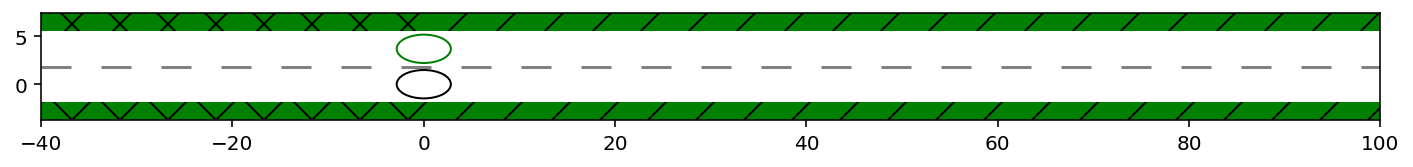

In [158]:
cmplot.plot_single_frame(world, amb_MPC, amb_x0.reshape(6,1), [x0.reshape(6,1) for x0 in all_other_x0], None, "ellipse", False, None, [0])

In [159]:
solver_params = {
    'slack':True,
    'solve_amb':False,
    'k_slack': 1000,
    'k_CA': 0.05,
    'k_CA_power': 1,
    'wall_CA': False,
}
ipopt_params = {
    'print_level':0,
}


In [160]:
response_MPC = all_other_MPC[0]
response_x0 = all_other_x0[0]
nonresponse_x0_list = []
bri = mpc.MultiMPC(response_MPC, amb_MPC, [], world, solver_params)
bri.generate_optimization(params["N"], params["T"], response_x0, amb_x0, nonresponse_x0_list,  slack=solver_params['slack'], solve_amb=solver_params['solve_amb'], params=params, ipopt_params=ipopt_params)


## Provide a Trajectory

##### Ambulance Trajectory

In [161]:
u_warm_profiles, ux_warm_profiles = mpc.generate_warm_u(params["N"], amb_MPC, amb_x0)
warm_velocity = amb_x0[4]
x_warm_profiles, x_ux_warm_profiles = mpc.generate_warm_x(amb_MPC, world,  amb_x0, warm_velocity)
ux_warm_profiles.update(x_ux_warm_profiles) # combine into one

uamb, xamb, xamb_des = ux_warm_profiles['none none']

bri.opti.set_value(bri.xamb_opt, xamb)
bri.opti.set_value(bri.xamb_desired, xamb_des)
bri.opti.set_value(bri.uamb_opt, uamb)

##### Ado Trajectory

In [162]:
u_warm_profiles, ux_warm_profiles = mpc.generate_warm_u(params["N"], response_MPC, response_x0)
warm_velocity = response_x0[4]
x_warm_profiles, x_ux_warm_profiles = mpc.generate_warm_x(response_MPC, world,  response_x0, warm_velocity)
ux_warm_profiles.update(x_ux_warm_profiles) # combine into one

u, x, x_des = ux_warm_profiles['none none']

bri.opti.set_initial(bri.x_opt, x)
bri.opti.set_initial(bri.x_desired, x_des)
bri.opti.set_initial(bri.u_opt, u)            
bri.opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 392.00us ( 26.13us) 393.30us ( 26.22us)        15
       nlp_g  | 527.00us ( 35.13us) 525.30us ( 35.02us)        15
    nlp_grad  | 138.00us (138.00us) 137.83us (137.83us)         1
  nlp_grad_f  | 767.00us ( 47.94us) 770.50us ( 48.16us)        16
  nlp_hess_l  |   3.29ms (235.36us)   3.31ms (236.29us)        14
   nlp_jac_g  |   1.51ms ( 94.44us)   1.50ms ( 93.50us)        16
       total  |  13.50ms ( 13.50ms)  13.46ms ( 13.46ms)         1


OptiSol(Opti {
  instance #17
  #variables: 4 (nx = 26)
  #parameters: 4 (np = 26)
  #constraints: 19 (ng = 42)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [163]:
amb_x = bri.opti.value(bri.xamb_opt)
response_x = bri.opti.value(bri.x_opt)

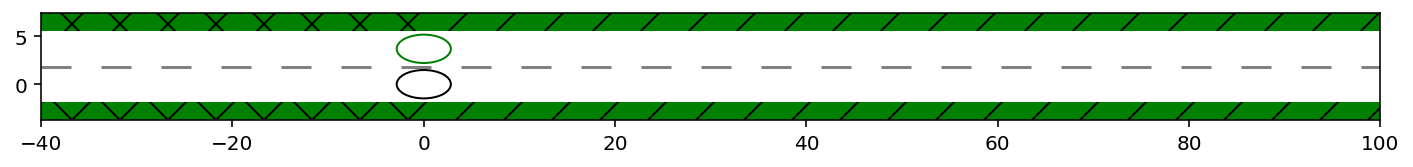

In [164]:
for k in range(params["N"]):
    cmplot.plot_single_frame(world, amb_MPC, amb_x, [response_x], None, "ellipse", False, None, [0])

### Get the Costs

In [165]:
costs = {
    "slack_cost": bri.slack_cost,
    "response_cost": bri.car1_costs,
    "amb_cost": bri.amb_costs,
    "response_svo": bri.response_svo_cost,
    "other_svo": bri.other_svo_cost,
}
for k in costs:
    print("%s: %0.03f"%(k, bri.opti.value(costs[k])))

slack_cost: 0.000
response_cost: -2.469
amb_cost: -2.448
response_svo: -1.746
other_svo: -1.731


In [166]:
print("Response Costs")
for idx in range(len(bri.car1_costs_list)):
    print("%s %.03f"%(bri.car1_cost_titles[idx], bri.opti.value(bri.car1_costs_list[idx])))
print(" ")
print("Ambulance Costs")
for idx in range(len(bri.amb_costs_list)):
    print("%s %.03f"%(bri.amb_cost[idx], bri.opti.value(bri.amb_costs_list[idx])))

Response Costs
self.k_u_delta * self.u_delta_cost 0.000
self.k_u_v * self.u_v_cost 0.003
self.k_lat * self.lat_cost 0.000
self.k_lon * self.lon_cost 0.000
self.k_phi_error * self.phi_error_cost 0.000
self.k_phi_dot * self.phidot_cost 0.000
self.k_s * self.s_cost 0.000
self.k_v * self.v_cost 0.000
self.k_change_u_v * self.change_u_v 0.000
self.k_change_u_delta * self.change_u_delta 0.000
self.k_final * self.final_costs 0.000
self.k_x * self.x_cost 0.000
self.k_x_dot * self.x_dot_cost -2.473
 
Ambulance Costs
self.k_u_delta * self.u_delta_cost 0.000
self.k_u_v * self.u_v_cost 0.000
self.k_lat * self.lat_cost 0.000
self.k_lon * self.lon_cost 0.000
self.k_phi_error * self.phi_error_cost 0.000
self.k_phi_dot * self.phidot_cost 0.000
self.k_s * self.s_cost 0.000
self.k_v * self.v_cost 0.000
self.k_change_u_v * self.change_u_v 0.000
self.k_change_u_delta * self.change_u_delta 0.000
self.k_final * self.final_costs 0.000
self.k_x * self.x_cost 0.000
self.k_x_dot * self.x_dot_cost -2.448


In [167]:
print("Total Amounts:")
print("Total: %0.03f"%bri.opti.value(bri.total_svo_cost))
print("  i: %0.03f"%bri.opti.value(bri.response_svo_cost))
print("  j: %0.03f"%bri.opti.value(bri.other_svo_cost))
print("  sl: %0.03f"%bri.opti.value(bri.k_slack * bri.slack_cost))
print("  ca: %0.03f"%bri.opti.value(bri.k_CA * bri.collision_cost))

Total Amounts:
Total: -3.098
  i: -1.746
  j: -1.731
  sl: 0.000
  ca: 0.379


### Let us compute the collision cost

In [145]:
# Proxy for the collision avoidance points on each vehicle

pairwise_distances = [] #keep track of all the distances between ego and ado vehicles
collision_cost = 0
# Collision Avoidance

for k in range(1):
    if bri.ambMPC:  # Don't forget the ambulance collision avoidance   
        dist = bri.minkowski_ellipse_collision_distance(bri.responseMPC, bri.ambMPC, 
                                                            bri.x_opt[0, k], bri.x_opt[1,k], bri.x_opt[2,k], 
                                                            bri.xamb_opt[0,k], bri.xamb_opt[1,k], bri.xamb_opt[2,k])

#         self.opti.subject_to(dist >= 1 - self.slack_amb[center_i, k] )         
#         self.pairwise_distances += [dist]
        distance_clipped = cas.fmax(dist, 0.00001)
        collision_cost = 1/distance_clipped**bri.k_CA_power
        
print(bri.opti.value(dist))

1.5582525163819838


In [146]:
test_point_ado = (3, 0, 0)
test_point_amb = (0, 0, 0)

In [147]:
dist = bri.minkowski_ellipse_collision_distance(bri.responseMPC, bri.ambMPC, 
                                                test_point_ado[0], test_point_ado[1], test_point_ado[2], 
                                               test_point_amb[0], test_point_amb[1], test_point_amb[2])
distance_clipped = cas.fmax(dist, 0.00001)
collision_cost = 1/distance_clipped**bri.k_CA_power

## Sample Plotting

#### Generating Collision Cost

(0.0, 3.0)

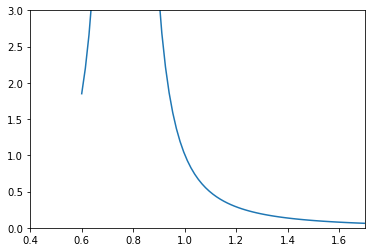

In [151]:
# Define the values at d^2 = 1 (c1) and d^2 = 1.5 (c15)
x = np.linspace(0.6, 2, 100)
x1 = 1.0
x15 = 1.5
## set the costs at these two points to define collision cost
c1 = 1.0
c15 = 0.1

k2s = np.roots([(1-c1/c15), (-2*(x15) + 2*(x1)*c1/c15), ((x15**2)-(x1**2)*c1/c15)])
kc2 = min(k2s)
kc1 = c1*(1-kc2)**2
kc1, kc2
plt.plot(x, kc1/(x-kc2)**2)
plt.xlim([.4, 1.7])
plt.ylim([0, 3])

In [150]:
kc2

0.768762352212868

In [149]:
kc1

0.05347084975412569

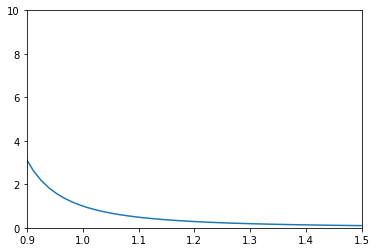

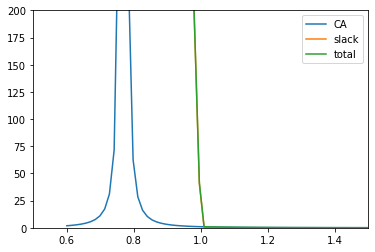

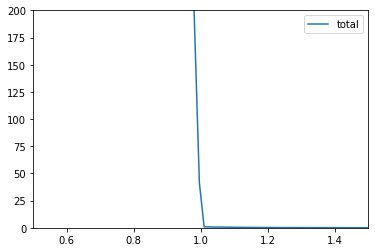

In [124]:
x = np.linspace(0.6, 2, 100)
k_s2 = 100
k_s1 = 100

s = np.clip(1-x, 0, np.infty)
slack_cost = k_s1*s*(s + k_s2)
ca_cost = kc1/(x-kc2)**2
plt.plot(x, ca_cost, label="CA")
plt.xlim([0.9, 1.5])
plt.ylim([0, 10])
plt.show()

plt.plot(x, ca_cost, label="CA")
plt.plot(x, slack_cost, label="slack")
plt.plot(x, ca_cost + slack_cost, label='total')
plt.legend()
plt.xlim([0.5,  1.5])
plt.ylim([0, 200])
plt.show()


plt.plot(x, ca_cost + slack_cost, label='total')
plt.legend()
plt.xlim([0.5,  1.5])
plt.ylim([0, 200])
plt.show()

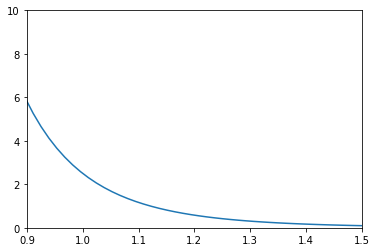

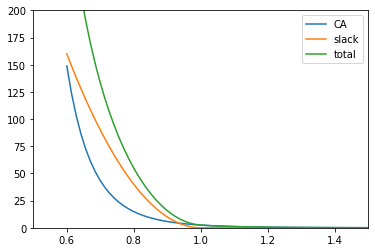

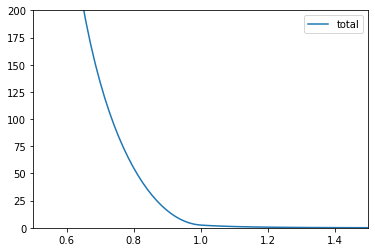

In [128]:
x = np.linspace(0.6, 2, 100)
k_s2 = 0
k_s1 = 1000

s = np.clip(1-x, 0, np.infty)
slack_cost = k_s1*s*(s + k_s2)
ca_cost = 2.5/x**8
plt.plot(x, ca_cost, label="CA")
plt.xlim([0.9, 1.5])
plt.ylim([0, 10])
plt.show()

plt.plot(x, ca_cost, label="CA")
plt.plot(x, slack_cost, label="slack")
plt.plot(x, ca_cost + slack_cost, label='total')
plt.legend()
plt.xlim([0.5,  1.5])
plt.ylim([0, 200])
plt.show()


plt.plot(x, ca_cost + slack_cost, label='total')
plt.legend()
plt.xlim([0.5,  1.5])
plt.ylim([0, 200])
plt.show()

In [108]:
bri.opti.value(collision_cost), bri.opti.value(dist), bri.opti.value(distance_clipped)

(0.6417445115518514, 1.5582525163819845, 1.5582525163819845)

In [62]:
def get_ellipse(L, W):
    min_elipse_a =  lambda a: (1 - L**2/(2*a)**2 - W**2/(2*a + W - L)**2)
    
    ax = scipy.optimize.fsolve(min_elipse_a, L/2.0)
    by = ax + .5*(W-L)
    return ax, by

def R(phi):
    return np.array([[np.cos(phi), np.sin(phi)],[-np.sin(phi), np.cos(phi)]])


def Q_minkowski(R_e, M_e, R_a, M_a):
    '''Aaron's Code'''
    M_e_curr = R_e @ M_e
    M_a_curr = R_a @ M_a
    Q1 = M_e_curr @ M_e_curr.T
    Q2 = M_a_curr @ M_a_curr.T
    beta = np.sqrt(np.trace(Q1) / np.trace(Q2))
    Q_minkowski = (1+1/beta) * Q1 + (1+beta) * Q2
    return Q_minkowski

def dist_squared(Xe, Xa, Q_minkowski):
    ### Ellipse is Ego centered
    return (Xa - Xe).T @ np.linalg.inv(Q_minkowski) @ (Xa - Xe)

In [63]:
R_e = np.eye(2)
M_e = np.eye(2)*2
R_a = np.eye(2)
M_a = np.eye(2)*3

In [64]:
Q = Q_minkowski(R_e, M_e, R_a, M_a)
Q

array([[25.,  0.],
       [ 0., 25.]])

In [65]:
c = np.array([[0],[0]])

In [66]:
xt = np.array([[4],[0]])
xt.T @ np.linalg.inv(Q) @ xt <= 1

array([[ True]])

In [67]:
W = 1.8
L = 4.5


phi_e = 0 * np.pi/180
phi_a = 5 * np.pi/180

a_e, b_e = get_ellipse(ego_veh.L, ego_veh.W)
a_a, b_a = get_ellipse(ado_veh.L, ado_veh.W)

# M_e =  np.array([[1/a_e**2, 0],[0, 1/b_e**2]], dtype=float)
# M_a =  np.array([[1/a_a**2, 0],[0, 1/b_a**2]], dtype=float)
M_e =  np.array([[a_e, 0],[0, b_e]], dtype=float)
M_a =  np.array([[a_a, 0],[0, b_a]], dtype=float)


R_e = R(phi_e)
R_a = R(phi_a)

x_e, y_e = 0, 1
x_a, y_a = 6.5, 0
Xe = np.array([[x_e],[y_e]])
Xa = np.array([[x_a], [y_a]])

## Calculate the Ellipse Obstacle

### Plot the Ellipses

[[3.0470399]] 3.40712
[[0.2760363]] 0.254728
[[3.166157]] 3.45216
[[0.2419356]] 0.217286
[[0.0032519]] 0.00336644
[[2.5239549]] 2.58612
[[0.4627894]] 0.516615
[[2.2801529]] 2.49814
[[0.51091]] 0.455221
[[1.604878]] 1.80936
[[0.3385863]] 0.300691
[[1.9067687]] 2.0163
[[1.6321405]] 1.4752
[[0.7473976]] 0.738103
[[0.8524958]] 0.952471
[[1.6976784]] 1.51292
[[2.7878761]] 2.68958
[[3.2537331]] 3.0212
[[5.1538497]] 4.68746
[[2.17855]] 1.9375
[[2.5485831]] 2.49674
[[0.9616958]] 0.932854
[[2.7230735]] 2.58123
[[0.986027]] 0.899451
[[2.8938647]] 2.96999
[[3.0013181]] 2.67704
[[1.6050476]] 1.44619
[[1.4717742]] 1.38697
[[0.3616873]] 0.360965
[[0.7102612]] 0.742315


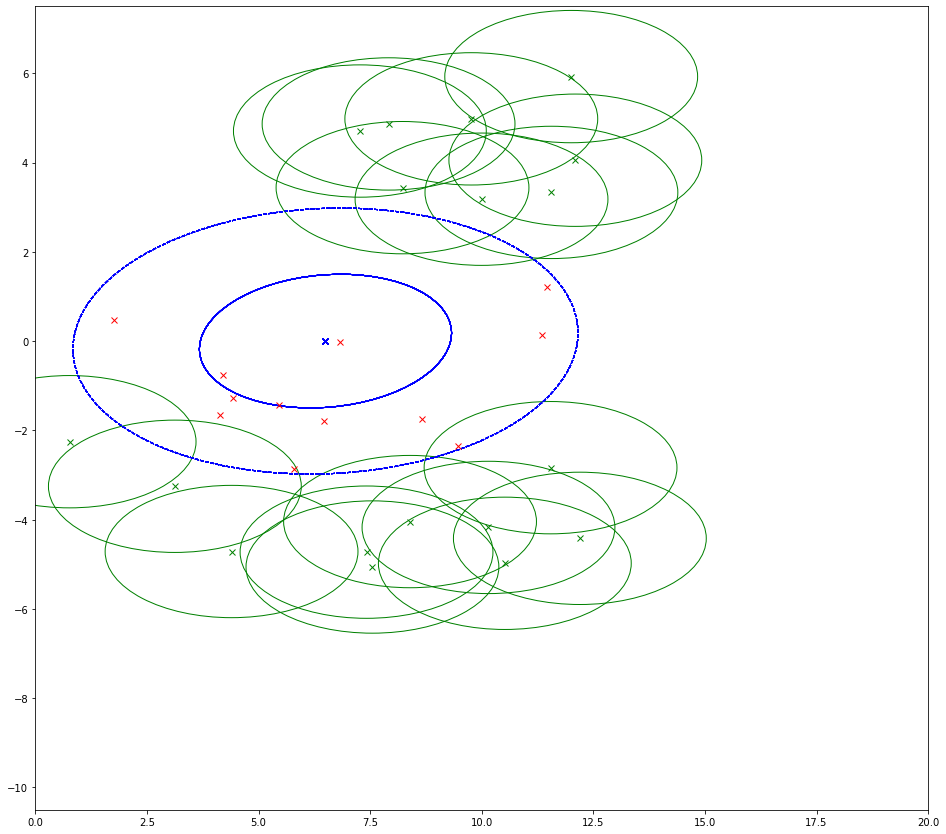

In [76]:
fig, ax = plt.subplots(1,1,figsize=(16,16))
all_pts = []
for i_test_point in range(30):
#     fig = plt.figure(edgecolor='red')
    x_e = x_a + np.random.uniform(-6,6)
    y_e = y_a + np.random.uniform(-6, 6)    
    phi_e = 0 * np.pi/180
    
    
    
    Xa = np.array([[x_a], [y_a]])
    
    Xe = np.array([[x_e],[y_e]])
    plt.plot(x_a, y_a, 'x', color='blue')

    ax = plt.gca()
    ax.axis('square')
    # ax.add_patch(c)
    plt.xlim([0, 20])
    plt.ylim([-10.5, 7.5])
    
    e2 = patches.Ellipse((x_a, y_a), 2*a_a, 2*b_a, angle=np.rad2deg(phi_a), fill=False, edgecolor='blue')
    ax.add_patch(e2)

    Q_m = Q_minkowski(R_e, M_e, R_a, M_a)
    d = dist_squared(Xa, Xe, Q_m)
    collision = d <= 1
    dist_squared1 = mpc_example.minkowski_ellipse_collision_distance(ego_veh, ado_veh, x_e, y_e, phi_e, x_a, y_a, phi_a)
    collision1 = dist_squared1 <= 1
    if collision1:
        color = 'red'
    else:
        color = 'green'
    plt.plot(x_e, y_e, 'x', color=color)
    if not collision1:
        e1 = patches.Ellipse((x_e, y_e), 2*a_e, 2*b_e, angle=np.rad2deg(phi_e), fill=False, edgecolor=color)
        ax.add_patch(e1)
    print(d, dist_squared1)


    w, v = np.linalg.eig(Q_m)
    a_q, b_q = np.sqrt(w[0]), np.sqrt(w[1])
    v = v.T
    phi_q = np.arctan2(v[1,0], v[0,0])
    qp = patches.Ellipse((x_a, y_a), 2*a_q, 2*b_q, angle=np.rad2deg(phi_q), fill=False, edgecolor='blue', linestyle='--')
    ax.add_patch(qp)
    
    all_pts += [(x_e, y_e, dist_squared1)]

#     plt.setp(ax.spines.values(), color=color)    
#     fig.set_edgecolor('red')
plt.show()

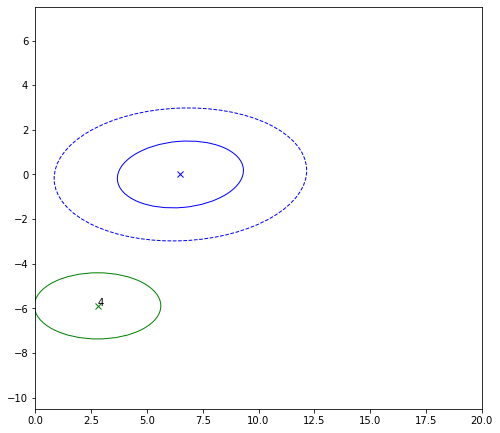

In [69]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
for i_test_point in [4]:

    x_e, y_e, dist_sqrd = all_pts[i_test_point]
    phi_e = 0 * np.pi/180
    
    
    
    Xa = np.array([[x_a], [y_a]])
    
    Xe = np.array([[x_e],[y_e]])
    plt.plot(x_a, y_a, 'x', color='blue')

    ax = plt.gca()
    ax.axis('square')
    # ax.add_patch(c)
    plt.xlim([0, 20])
    plt.ylim([-10.5, 7.5])
    
    e2 = patches.Ellipse((x_a, y_a), 2*a_a, 2*b_a, angle=np.rad2deg(phi_a), fill=False, edgecolor='blue')
    ax.add_patch(e2)

    Q_m = Q_minkowski(R_e, M_e, R_a, M_a)
    d = dist_squared(Xa, Xe, Q_m)
    collision = d <= 1
    dist_squared1 = mpc_example.minkowski_ellipse_collision_distance(ego_veh, ado_veh, x_e, y_e, phi_e, x_a, y_a, phi_a)
    collision1 = dist_squared1 <= 1
    if collision1:
        color = 'red'
    else:
        color = 'green'
    plt.plot(x_e, y_e, 'x', color=color)
#     if not collision1:
    e1 = patches.Ellipse((x_e, y_e), 2*a_e, 2*b_e, angle=np.rad2deg(phi_e), fill=False, edgecolor=color)
    ax.add_patch(e1)
    ax.annotate(str(i_test_point), (x_e, y_e))

    w, v = np.linalg.eig(Q_m)
    a_q, b_q = np.sqrt(w[0]), np.sqrt(w[1])
    v = v.T
    phi_q = np.arctan2(v[1,0], v[0,0])
    qp = patches.Ellipse((x_a, y_a), 2*a_q, 2*b_q, angle=np.rad2deg(phi_q), fill=False, edgecolor='blue', linestyle='--')
    ax.add_patch(qp)
    
#     all_pts += [(x_e, y_e, dist_squared1)]

#     plt.setp(ax.spines.values(), color=color)    
#     fig.set_edgecolor('red')
plt.show()

In [59]:
mpc_example.minkowski_ellipse_collision_distance(ego_veh, ado_veh, x_e, y_e, phi_e, x_a, y_a, phi_a)

DM(1.08704)

In [58]:
mpc_example.minkowski_ellipse_collision_distance(ego_veh, ado_veh, x_e, y_e, phi_e, x_a, y_a, 0)

DM(1.03119)

In [35]:
x_e, y_e, dsquared = all_pts[19]

In [36]:
Q_m

array([[31.99, -1.01],
       [-1.01,  8.87]])

In [37]:
X_ego = np.array([[x_e], [y_e]])
X_ado = np.array([[x_a], [y_a]])
(((-X_ado + X_ego).T @ np.linalg.inv(Q_m) @ (-X_ado + X_ego)))

array([[0.98]])

In [42]:
X_ego = cas.vertcat([[x_e], [y_e]])
X_ado = cas.vertcat([[x_a], [y_a]])
cas.mtimes([cas.transpose(X_ado - X_ego), cas.inv(Q_minkowski), (X_ado - X_ego)])

NotImplementedError: Wrong number or type of arguments for overloaded function '_vertcat'.
  Possible prototypes are:
    _vertcat([Sparsity])
    _vertcat([DM])
    _vertcat([SX])
    _vertcat([MX])
  You have: '(([[float]]))'


In [18]:
x_e, y_e, dc = all_pts[19]
x_e, y_e, dc

(9.661742724591697, -2.5223279957851434, DM(0.976109))

In [19]:
phi_e

0.0

In [17]:
x_a, y_a, phi_a

(6.5, 0, 0.08726646259971647)

In [20]:
dist_squared1 = mpc_example.minkowski_ellipse_collision_distance(ego_veh, ado_veh, x_e, y_e, phi_e, x_a, y_a, phi_a)


In [21]:
float(dist_squared1)

0.9761091949982597

In [204]:
Q = Q_minkowski(R_e, M_e, R_a, M_a)


In [206]:
e = np.linalg.eig(np.linalg.inv(Q))

In [207]:
e

(array([0.04, 0.08]), array([[-0.91, -0.42],
        [ 0.42, -0.91]]))

In [117]:
(Xa - Xe).T @ np.linalg.inv(Q_m) @ (Xa-Xe)

array([[0.75]])

[[ True]]


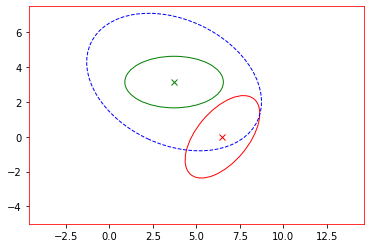

In [166]:
phi_e = 0 * np.pi/180

Xe = np.array([[x_e],[y_e]])
plt.plot(x_e, y_e, 'x', color='green')
plt.plot(x_a, y_a, 'x', color='red')

ax = plt.gca()
ax.axis('equal')
# ax.add_patch(c)
plt.xlim([-5, 15])
plt.ylim([-5, 7.5])


e1 = patches.Ellipse((x_e, y_e), 2*a_e, 2*b_e, angle=np.rad2deg(phi_e), fill=False, edgecolor='green')
ax.add_patch(e1)

e2 = patches.Ellipse((x_a, y_a), 2*a_a, 2*b_a, angle=np.rad2deg(phi_a), fill=False, edgecolor='red')
ax.add_patch(e2)

Q_m = Q_minkowski(R_e, M_e, R_a, M_a)
w, v = np.linalg.eig(Q_m)
a_q, b_q = np.sqrt(w[0]), np.sqrt(w[1])
# v = v.T
phi_q = np.arctan2(v[1,0], v[0,0])
qp = patches.Ellipse((x_e, y_e), 2*a_q, 2*b_q, angle=np.rad2deg(phi_q), fill=False, edgecolor='blue', linestyle='--')
ax.add_patch(qp)

collision = dist_squared(Xa, Xe, Q_m) <= 1
print(collision)
if collision:
    color = 'red'
else:
    color = 'green'
plt.setp(ax.spines.values(), color=color)    
#     fig.set_edgecolor('red')
plt.show()

In [149]:
t = np.linspace(0, 2*np.pi)
n = len(t)
x1 = np.cos(t).reshape(1,n)
x2 = np.sin(t).reshape(1,n)
X = np.concatenate((x1,x2), axis=0)
Y = Q_m @ (X - Xe)

(-208.71155052182945,
 -151.7843897134392,
 -17.956463477796415,
 18.615679010588213)

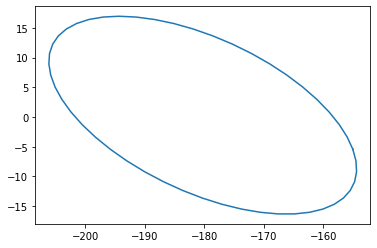

In [150]:
plt.plot(Y[0,:], Y[1,:])
ax = plt.gca()
ax.axis('equal')


In [103]:
np.rad2deg(phi_q)

25.000000000000004

In [265]:
Xe, Xa,((Xa - Xe).T @ np.linalg.inv(Q_minkowski) @ (Xa - Xe))


(array([[0],
        [1]]), array([[6.5],
        [0. ]]), array([[1.69]]))

In [255]:
((Xe - Xa)/T * np.linalg.inv(Q_minkowski) * (Xe - Xa).T) 

array([[ 1.83, -0.1 ],
       [-0.1 ,  0.07]])

[[False]]


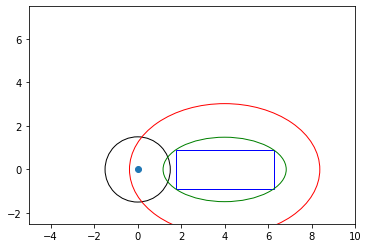

In [16]:
### Another way to see it as following
plt.plot(x_e, y_e,'o')
c = patches.Circle((x_e, y_e), radius=r, fill=None)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c)
plt.xlim([-5, 10])
plt.ylim([-2.5, 7.5])

plt.plot(x_o, y_o)
a = 2.832
b = 1.4820


# a_val = 4.5
# b_val = 1.8
W = 1.8
L = 4.5
rec = patches.Rectangle((x_o-L/2, y_o-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
a_val = 2.832
b_val = 1.4820

delta = 0.0447


# a_val, b_val = 3.897114298575689, 1.1022703788869466
e = patches.Ellipse((x_o, y_o), 2*(a_val), 2*(b_val), fill=False, edgecolor='green')
e_b = patches.Ellipse((x_o, y_o), 2*(a_val+delta+r), 2*(b_val+delta+r), fill=False, edgecolor='red')
ax.add_patch(e)
ax.add_patch(e_b)

collision_free = (np.array([[dx],[dy]]).T @ R_o.T @ np.array([[1/alpha**2, 0],[0, 1/beta**2]]) @ R_o @ np.array([[dx],[dy]])) > 1
print(collision_free)

In [ ]:
import casadi as cas

In [ ]:
opti = cas.Opti()
a = opti.variable()
b = opti.variable()
opti.minimize(a*b**2)
opti.subject_to( ((L/2)**2/a**2 + (W/2)**2/b**2) <= 1)
opti.subject_to(a>0)
opti.subject_to(b>0)
opti.solver('ipopt')

In [ ]:
opti.set_initial(a, 1)
opti.set_initial(b, 1.5)
solution = opti.solve()

In [ ]:
a_val = solution.value(a)
b_val = solution.value(b)
print(a_val, b_val)

In [ ]:
(L/2)**2/a_val**2 + (W/2)**2/b_val**2

In [ ]:
plt.plot([a_val*np.cos(t) for t in np.linspace(0, 2*np.pi, 50)], [b_val*np.sin(t) for t in np.linspace(0, 2*np.pi, 50)])

## From MATLAB

In [ ]:
clear all 
close all
clc 

%% 
W = 1.8;
L = 4.5;

min_elipse_box = @(a) (1 - L^2/(2*a)^2 - W^2/(2*a + W - L)^2) ;
a = fzero(min_elipse_box, 10)
b = a + 1/2*(W-L)
t = 0:.1:2*pi;
x = a*cos(t);
y = b*sin(t);
plot(x,y)
rectangle('Position',[-L/2 -W/2 L W])
axis('equal')
hold on
 
%% ellipsoid and circle dimensions
%a = 10; 
%b = 2; 
r = 1.5;
 
M = 400; 
dtheta = 2*pi / M; 
theta_M = (0 : dtheta : 2*pi)'; 


minimal_positive_root = @(delta) (2*(delta + r)^2*(2*a*b + a*(delta + r) + b*(delta + r)))/((a + b)*(a + b + 2*delta + 2*r))-r^2; 
x0 = 1.5; % initial guess must be always positive
delta = fzero(minimal_positive_root,x0)
disp(delta)
a_new = a+delta+r
b_new = b+delta+r

x = a_new*cos(t);
y = b_new*sin(t);
plot(x,y)

%%

for i = 1 : M+1 
    theta = theta_M(i); 
    
    %% ellipse coordinates
    x_M(i) = a * cos(theta); 
    y_M(i) = b * sin(theta); 
     
    alpha = a+delta+r; 
    beta = b+delta+r; 

    %% bounding ellipse
    
    x_1_M(i) = alpha * cos(theta); 
    y_1_M(i) = beta * sin(theta); 
    
    %% Minkowsky sum of ellipse (a,b) and circle r
    x_2_M(i) = a*cos(theta) + r*cos(theta)/(sqrt((cos(theta))^2 + (a^2/b^2)*(sin(theta))^2)); 
    y_2_M(i) = b*sin(theta) + r*sin(theta)/(sqrt((b^2/a^2)*(cos(theta))^2 + (sin(theta))^2));    
     

    %% previously used bounding ellipse
    a_3 = a + r; 
    b_3 = b + r; 
    x_3_M(i) = a_3 * cos(theta); 
    y_3_M(i) = b_3 * sin(theta); 
     
    %% circle coordinates
    x_4_M(i) = r * cos(theta); 
    y_4_M(i) = r * sin(theta); 
end 

h=figure; 
hold all; 
box on; 
grid on; 
axis equal; 
plot(x_M, y_M, '-r') 

plot(x_1_M, y_1_M, '-k') 
plot(x_2_M, y_2_M, '-b') 
plot(x_3_M, y_3_M, '-r')
legend("Ellipse","Minimal Bounding ellipse","Minkowski Sum","Bound Ellipse + Circle","Circle")
% legend(h,'off')
plot(x_4_M, y_4_M, '-g') 
% circle(0,0,a+r)


K = randi([floor(M/4/4), ceil(M/4/2)]); 
theta = theta_M(K); 
x = a * cos(theta); 
y = b * sin(theta); 
plot([0,x], [0, y], '-k') 
normal = r*[2*cos(theta)/a; 2*sin(theta)/b] / norm([2*cos(theta)/a; 2*sin(theta)/b]); 
plot([0, normal(1)], [0, normal(2)], '-b') 
plot([x, normal(1)+x], [y, normal(2)+y], '-b')
circle(normal(1)+x, normal(2)+y, r)
hold all
 
% theta_T = theta_M(1 : ceil(M/2)+1); 
% theta_T = theta_M; 
% delta_x_T = cos(theta_T) .* (r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)) - 1); 
% delta_y_T = sin(theta_T) .* (r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)) - 1); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_x_T, '-k'); 
% plot(delta_y_T, '-r'); 
%  
% delta_a_T = r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)); 
% delta_b_T = r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_a_T, '-k'); 
% plot(delta_b_T, '-r'); 

%%Curvature calculation
% k=a*b/(sqrt(a^2/2+b^2/2)^3)
% k_r=(a+r)*(b+r)/(sqrt((a+r)^2/2+(b+r)^2/2)^3)
% t=0:0.01:2*pi
% figure;
% plot(t,a.*b./(sqrt(a.^2.*cos(t).^2+b.^2.*sin(t).^2).^3))
% hold on;
% ar=a+r;
% br=b+r;
% plot(t,ar.*br./(sqrt(ar.^2.*cos(t).^2+br.^2.*sin(t).^2).^3),'b')
% figure;
% plot(t,a^2.*cos(t).^2+b^2.*sin(t).^2)

function h = circle(x,y,r)
    hold on
    th = 0:pi/50:2*pi;
    xunit = r * cos(th) + x;
    yunit = r * sin(th) + y;
    h = plot(xunit, yunit);
%     hold off
end



